In [2]:
import os
import sys
import time
import random
import cv2 as cv
import numpy as np
from PIL import Image
from numpy import genfromtxt
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D

np.random.seed(1337)  # for reproducibility

Using TensorFlow backend.


In [3]:
import keras

print(keras.__version__)

2.2.4


In [4]:
def view_bar(num, total, part):
    rate = num / total
    rate_num = int(rate * 100)
    r = '\r%s:  %d%%' % (part, rate_num)
    sys.stdout.write(r)
    sys.stdout.flush()

In [5]:
def show_train_history(train_acc, test_acc):
    plt.plot(train_history.history[train_acc])
    plt.plot(train_history.history[test_acc])
    plt.title('Train History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(BASE_PATH + 'acc.png')
    plt.show()

In [6]:
BASE_PATH = 'C:\\Users\\Robert\\Google 雲端硬碟\\Colab Notebooks\\how-push-you-are\\face\\32by32\\'
PATHS     = ['mark0', 'mark1', 'mark2'] # and this
NUMBER_OF_IMG_TEST  = 5400
NUMBER_OF_IMG_TRAIN = 42000
NUMBER_OF_CATEGORY  = 3
IMG_SIZE            = 32


In [7]:
# define model
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3, 3),
                 padding='same',
                 input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                 activation='relu', name='conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1'))
model.add(Conv2D(filters=64,
                 kernel_size=(3, 3),
                 padding='same',
                 activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2'))
model.add(Dropout(0.25, name='fc1'))
model.add(Conv2D(filters=128,
                 kernel_size=(3, 3),
                 padding='valid',
                 activation='relu', name='conv3'))
model.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_3'))
model.add(Dropout(0.25, name='fc2'))
model.add(Flatten())
model.add(Dense(64, activation='relu', name='fc3'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', name='fc4'))
model.add(Dense(NUMBER_OF_CATEGORY, activation='softmax', name='output'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
fc1 (Dropout)                (None, 8, 8, 64)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 6, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 128)         0         
__________

In [8]:
mark0 = []
mark1 = []
mark2 = []

# load ptt-beauty pictures
for path in PATHS:
    for files in os.listdir(BASE_PATH + path):
        
        if path == 'mark0':
            mark0.append(files)
        elif path == 'mark1':
            mark1.append(files)
        elif path == 'mark2':
            mark2.append(files)
        else:
            print('error')
    print('%s done' %path)
    
random.shuffle(mark0) # Randomly shuffle the list content
random.shuffle(mark1)
random.shuffle(mark2)

mark0 done
mark1 done
mark2 done


Train Data loading:  99%
Train Data load done, cost 160.9 minutes

X_train shape:  (42000, 32, 32, 3)
Y_train shape:  (42000, 3)


Test Data loading:  99%
Train Data load done, cost 3.0 minutes

X_test shape:  (5400, 32, 32, 3)
Y_test shape:  (5400, 3)


Train on 33600 samples, validate on 8400 samples
Epoch 1/50
 - 40s - loss: 1.0996 - acc: 0.3323 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/50
 - 40s - loss: 1.0988 - acc: 0.3287 - val_loss: 1.0986 - val_acc: 0.3374
Epoch 3/50
 - 40s - loss: 1.0987 - acc: 0.3282 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/50
 - 40s - loss: 1.0986 - acc: 0.3314 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 5/50
 - 40s - loss: 1.0986 - acc: 0.3362 - val_loss: 1.0986 - val_acc: 0.3396
Epoch 6/50
 - 40s - loss: 1.0987 - acc: 0.3291 - val_loss: 1.0986 - val_acc: 0.3331
Epoch 7/50
 - 40s - loss: 1.0987 - acc: 0.3330 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 8/50
 - 40s - loss: 1.0988 - acc: 0.3285 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 9/50
 - 40s - loss

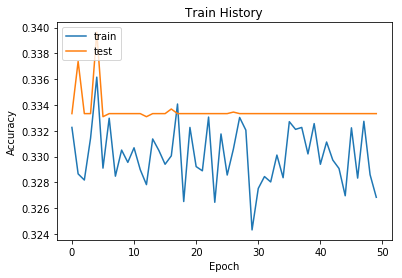

In [9]:
imgNames_mark0 = mark0[0:NUMBER_OF_IMG_TRAIN//3] # NUMBER_OF_IMG_TRAIN = 54000 
imgNames_mark1 = mark1[0:NUMBER_OF_IMG_TRAIN//3] # Take the first 54000/3 pictures for treaining.
imgNames_mark2 = mark2[0:NUMBER_OF_IMG_TRAIN//3]

del mark0[0:NUMBER_OF_IMG_TRAIN//3] # After take the first 54000/3 pictures, delete it. To avoid taking duplicates.
del mark1[0:NUMBER_OF_IMG_TRAIN//3]
del mark2[0:NUMBER_OF_IMG_TRAIN//3]

test_mark0 = mark0[0:NUMBER_OF_IMG_TEST//3] # NUMBER_OF_IMG_TEST = 9000
test_mark1 = mark1[0:NUMBER_OF_IMG_TEST//3] # Take the first 9000/3 pictures for testing.
test_mark2 = mark2[0:NUMBER_OF_IMG_TEST//3]
 
del mark0[0:NUMBER_OF_IMG_TEST] # After take the first 9000/3 pictures, delete it. To avoid taking duplicates.
del mark1[0:NUMBER_OF_IMG_TEST]
del mark2[0:NUMBER_OF_IMG_TEST]

image_list_X = np.array([])  # init
test_list_X = np.array([])


load_train_start = time.time() # load training data start time.
#------------------TRAINING DATA------------------
for count_of_load in range(NUMBER_OF_IMG_TRAIN//3):

    mark0_fileName = ''
    mark1_fileName = ''
    mark2_fileName = ''

    mark0_fileName = BASE_PATH + 'mark0\\' + imgNames_mark0[count_of_load]
    mark1_fileName = BASE_PATH + 'mark1\\' + imgNames_mark1[count_of_load]
    mark2_fileName = BASE_PATH + 'mark2\\' + imgNames_mark2[count_of_load]

    mark0_im = np.array([])
    mark1_im = np.array([])
    mark2_im = np.array([])

    mark0_im = np.array(Image.open(mark0_fileName), dtype=np.float)
    mark1_im = np.array(Image.open(mark1_fileName), dtype=np.float)
    mark2_im = np.array(Image.open(mark2_fileName), dtype=np.float)

    image_list_X = np.append(image_list_X, mark0_im)
    image_list_X = np.append(image_list_X, mark1_im)
    image_list_X = np.append(image_list_X, mark2_im)

    view_bar(count_of_load, NUMBER_OF_IMG_TRAIN//3, 'Train Data loading')

load_train_end = time.time()
load_train_total =(load_train_end-load_train_start)/60
print('\nTrain Data load done, cost %.1f minutes' %load_train_total)

X_train = image_list_X.reshape(int(image_list_X.shape[0]/IMG_SIZE/IMG_SIZE/3), IMG_SIZE, IMG_SIZE, 3).astype('float32')/255
Y_train = genfromtxt(BASE_PATH + "train_label.csv", delimiter=',').astype('int')

print('\nX_train shape: ',X_train.shape)
print('Y_train shape: ',Y_train.shape)
print('\n')
#----------------------------------------------


load_test_start = time.time() # load testing data start time.
#------------------TESTING DATA-------------------
for count_of_load in range(NUMBER_OF_IMG_TEST//3):

    mark0_fileName = ''
    mark1_fileName = ''
    mark2_fileName = ''

    mark0_fileName = BASE_PATH + 'mark0\\' + test_mark0[count_of_load]
    mark1_fileName = BASE_PATH + 'mark1\\' + test_mark1[count_of_load]
    mark2_fileName = BASE_PATH + 'mark2\\' + test_mark2[count_of_load]

    mark0_im = np.array([])
    mark1_im = np.array([])
    mark2_im = np.array([])

    mark0_im = np.array(Image.open(mark0_fileName), dtype=np.float)
    mark1_im = np.array(Image.open(mark1_fileName), dtype=np.float)
    mark2_im = np.array(Image.open(mark2_fileName), dtype=np.float)

    test_list_X = np.append(test_list_X, mark0_im)
    test_list_X = np.append(test_list_X, mark1_im)
    test_list_X = np.append(test_list_X, mark2_im)

    view_bar(count_of_load, NUMBER_OF_IMG_TEST//3, 'Test Data loading')
load_test_end = time.time()
load_test_total =(load_test_end-load_test_start)/60
print('\nTrain Data load done, cost %.1f minutes' %load_test_total)

X_test = test_list_X.reshape(int(test_list_X.shape[0]/IMG_SIZE/IMG_SIZE/3), IMG_SIZE, IMG_SIZE, 3).astype('float32')/255
Y_test = genfromtxt(BASE_PATH + "test_label.csv", delimiter=',').astype('int')

print('\nX_test shape: ',X_test.shape)
print('Y_test shape: ',Y_test.shape)
print('\n')
#----------------------------------------------


#----------------model train-------------------
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
train_history = model.fit(x=X_train, y=Y_train, validation_split=0.2, epochs=50, batch_size=300, verbose=2)
model.save(BASE_PATH + 'ptt_buaty_face.h5')
scores = model.evaluate(X_test, Y_test)
print('\ntest scores: %.2f' %scores[1])
show_train_history('acc', 'val_acc')